<a href="https://colab.research.google.com/github/Anyaoma/My-projects/blob/main/Supervised_Learning_stock_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### PROBLEM DEFINITION

Determining the future stock price of any institution becomes increasingly relevant in the finance landscape; it an be useful in derivatives pricing, investment analysis etc.
This project first identifies relevant feature categories that can predict the microsoft stock price - stock of interest. This includes picking assets from a sea of correlated assets (stocks, indices, commodities), techincal indicators (moving average, exponential moving average etc.) and fundamental analysis (ROE, P/E, Book value etc.) Selected assets include:

#### Stocks:
GOOGLE, IBM

#### Indices:
VIX, S&P500, Dow Jones

#### Currencies:
USD/JPY, GBP/USD

In addition to predicting the stock price
accurately, this case study will also demonstrate the infrastructure and
framework for each step of time series and supervised regression–
based modeling for stock price prediction. We will use the daily
closing price of the last 10 years, from 2014 onward.

#### LOAD DATA AND RELEVANT PYTHON LIBRARIES

In [ ]:
#Models for supervised regression

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor

In [ ]:
#Modules for Data analysis and model evaluation

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression


In [ ]:
!pip install tensorflow --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 818.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 58.9 MB/s eta 0:00:00
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.17.1
    Uninstalling tensorboard-2.17.1:
      Successfully uninstalled tensorboard-2.17.1
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.17.1
    Uninstalling tensorflow-2.17.1:
      Successfully uninstalled tensorflow-2.17.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.18.0 which is incompatible.


In [ ]:
#Modules for deep learning
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from keras.layers import LSTM
#from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm



In [ ]:
#Modules for Data preparation and Visualization

# pandas, pandas_datareader, numpy and matplotlib
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import yfinance as yfin
from matplotlib import pyplot
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from pandas.plotting import scatter_matrix
from statsmodels.graphics.tsaplots import plot_acf


In [ ]:
stk_tickers = ['MSFT', 'IBM', 'GOOGL']
ccy_tickers = ['DEXJPUS', 'DEXUSUK']
idx_tickers = ['SP500', 'DJIA', 'VIXCLS']
stk_data = yfin.download(stk_tickers,start='2019-07-15' )
ccy_data = web.DataReader(ccy_tickers, 'fred')
idx_data = web.DataReader(idx_tickers, 'fred')

stk_data = stk_data['Adj Close']

[*********************100%***********************]  3 of 3 completed


In [ ]:
return_period = 5
Y = np.log(stk_data.loc[:, 'MSFT']).diff(return_period).shift(-return_period) #predict returns 5 periods from this date
Y.name = Y.name+'_pred'
X1 = np.log(stk_data.loc[:, ('GOOGL','IBM')]).diff(return_period)
#X1.columns = X1.columns.droplevel()
X2 = np.log(ccy_data).diff(return_period)
X3 = np.log(idx_data).diff(return_period)
X4 = pd.concat([np.log(stk_data.loc[:, 'MSFT']).diff(i) for i in [return_period, return_period*3,return_period*6, return_period*12]], axis=1).dropna()
X4.columns = ['MSFT_DT', 'MSFT_3DT', 'MSFT_6DT','MSFT_12DT']
X = pd.concat([X1, X2, X3, X4], axis=1)
dataset = pd.concat([Y, X],axis=1).dropna().iloc[::return_period, :]
Y = dataset.loc[:, Y.name]
X = dataset.loc[:, X.columns]

#### EXPLORATORY DATA ANALYSIS

descriptive statistics, data visualization, and time
series analysis

In [ ]:
pd.set_option('display.precision', 3)
dataset.describe()

,MSFT_pred,GOOGL,IBM,DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_DT,MSFT_3DT,MSFT_6DT,MSFT_12DT
count,236.000,236.000,236.000,236.000,2.360e+02,236.000,236.000,236.000,236.000,236.000,236.000,236.000
mean,0.004,0.004,0.003,0.002,-4.505e-04,0.003,0.002,-0.002,0.005,0.015,0.026,0.053
std,0.041,0.043,0.038,0.013,1.387e-02,0.028,0.028,0.164,0.041,0.063,0.082,0.107
min,-0.179,-0.168,-0.231,-0.067,-7.267e-02,-0.198,-0.209,-0.622,-0.179,-0.282,-0.229,-0.298
25%,-0.019,-0.022,-0.016,-0.005,-6.854e-03,-0.012,-0.008,-0.073,-0.016,-0.024,-0.024,-0.016
50%,0.005,0.006,0.005,0.002,-1.393e-03,0.006,0.005,-0.009,0.007,0.018,0.037,0.058
75%,0.029,0.032,0.024,0.010,6.712e-03,0.018,0.014,0.061,0.029,0.055,0.086,0.129
max,0.126,0.124,0.118,0.041,6.246e-02,0.099,0.116,0.923,0.126,0.156,0.264,0.377


In [ ]:
dataset.head()

,MSFT_pred,GOOGL,IBM,DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_DT,MSFT_3DT,MSFT_6DT,MSFT_12DT
2020-01-02,0.009,0.018,0.003,-0.011,0.009,0.006,0.009,-0.014,0.020,0.061,0.070,0.162
2020-01-10,0.035,0.048,0.017,0.014,-0.002,0.009,0.007,-0.110,0.017,0.044,0.059,0.134
2020-01-17,-0.029,0.035,0.012,0.006,-0.002,0.019,0.018,-0.037,0.035,0.052,0.109,0.207
2020-01-28,0.085,-0.022,0.003,-0.007,-0.004,-0.014,-0.016,0.237,-0.006,0.040,0.077,0.138
2020-02-04,0.024,-0.004,0.066,0.002,0.003,0.006,0.003,-0.014,0.085,0.098,0.146,0.227


##### visualization

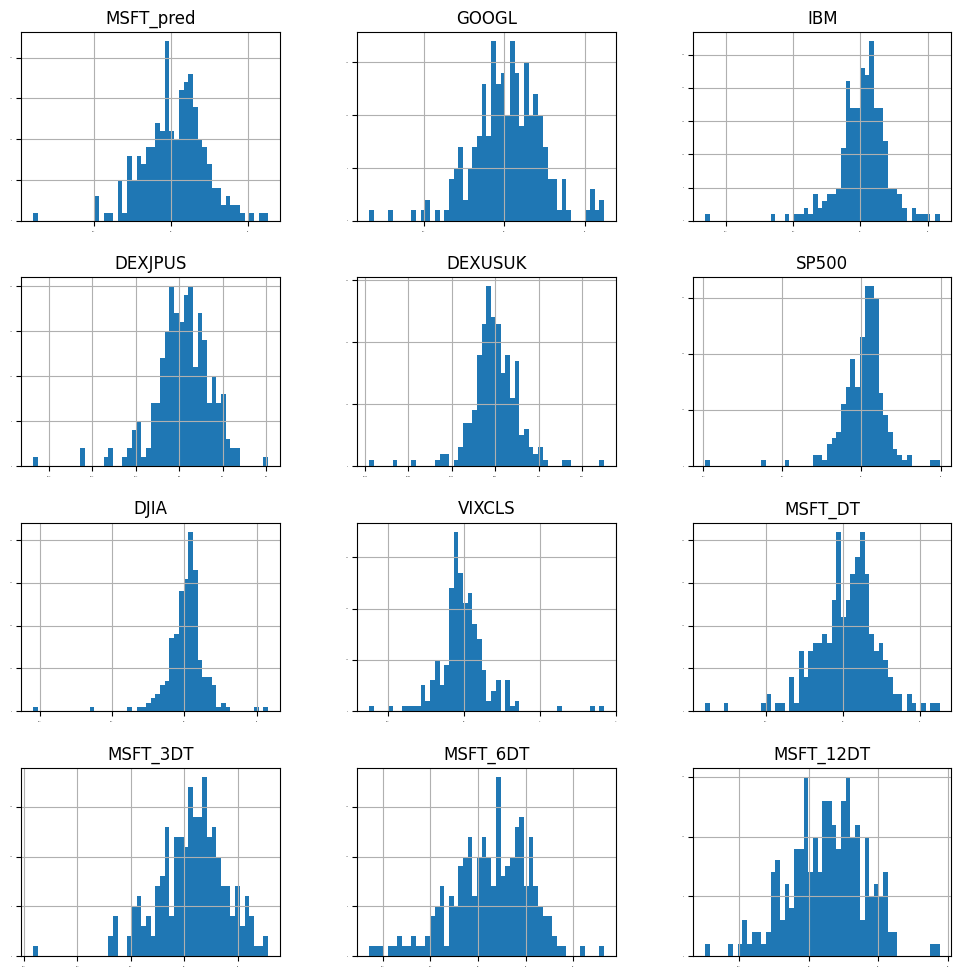

In [ ]:
dataset.hist(bins=50, sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
pyplot.show()

All variables exhibit left tailedness, showing presence of extreme losses, but majority of returns are positive.

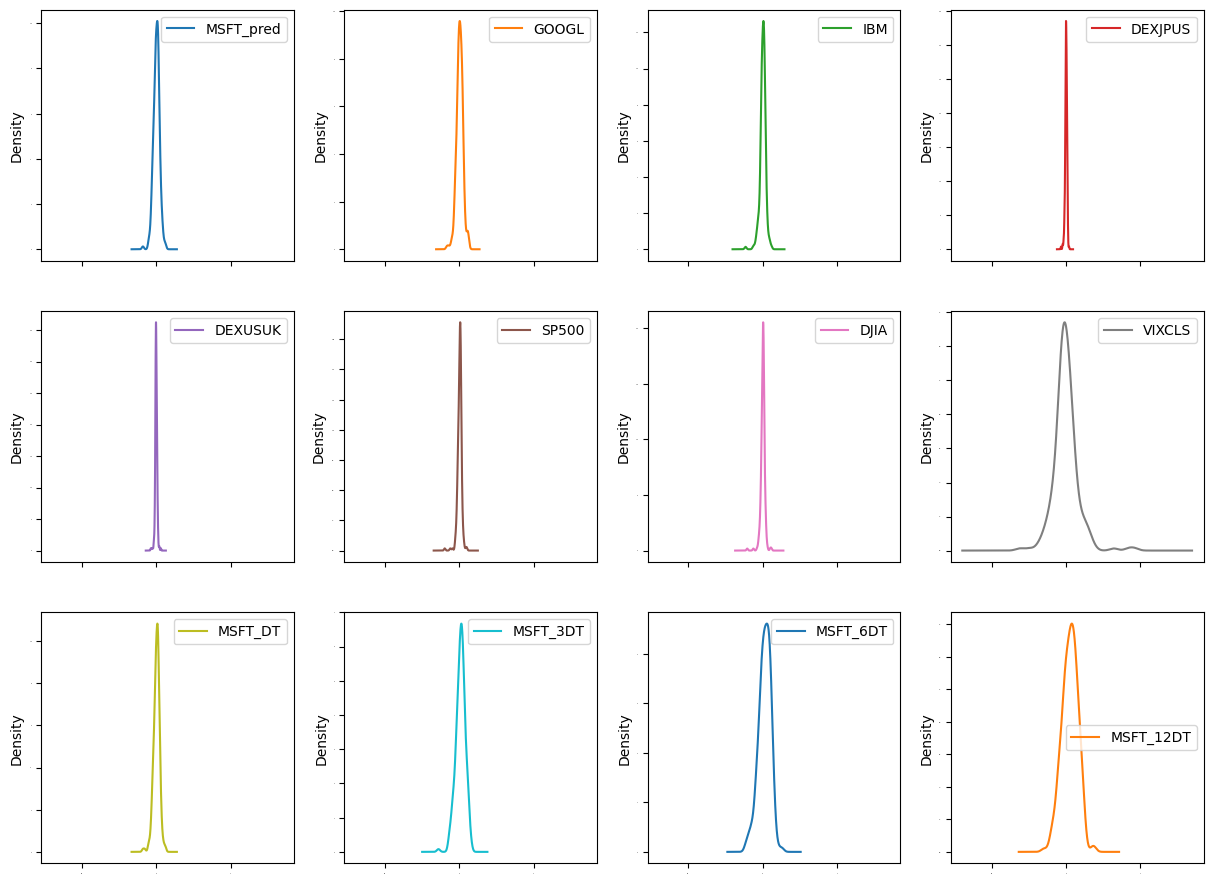

In [ ]:
dataset.plot(kind='density', subplots=True, layout=(4,4), sharex=True, legend=True, fontsize=1, figsize=(15,15))
pyplot.show()

VIX exhibits more variance than the rest of the variables

<Axes: title={'center': 'Correlation Matrix'}>

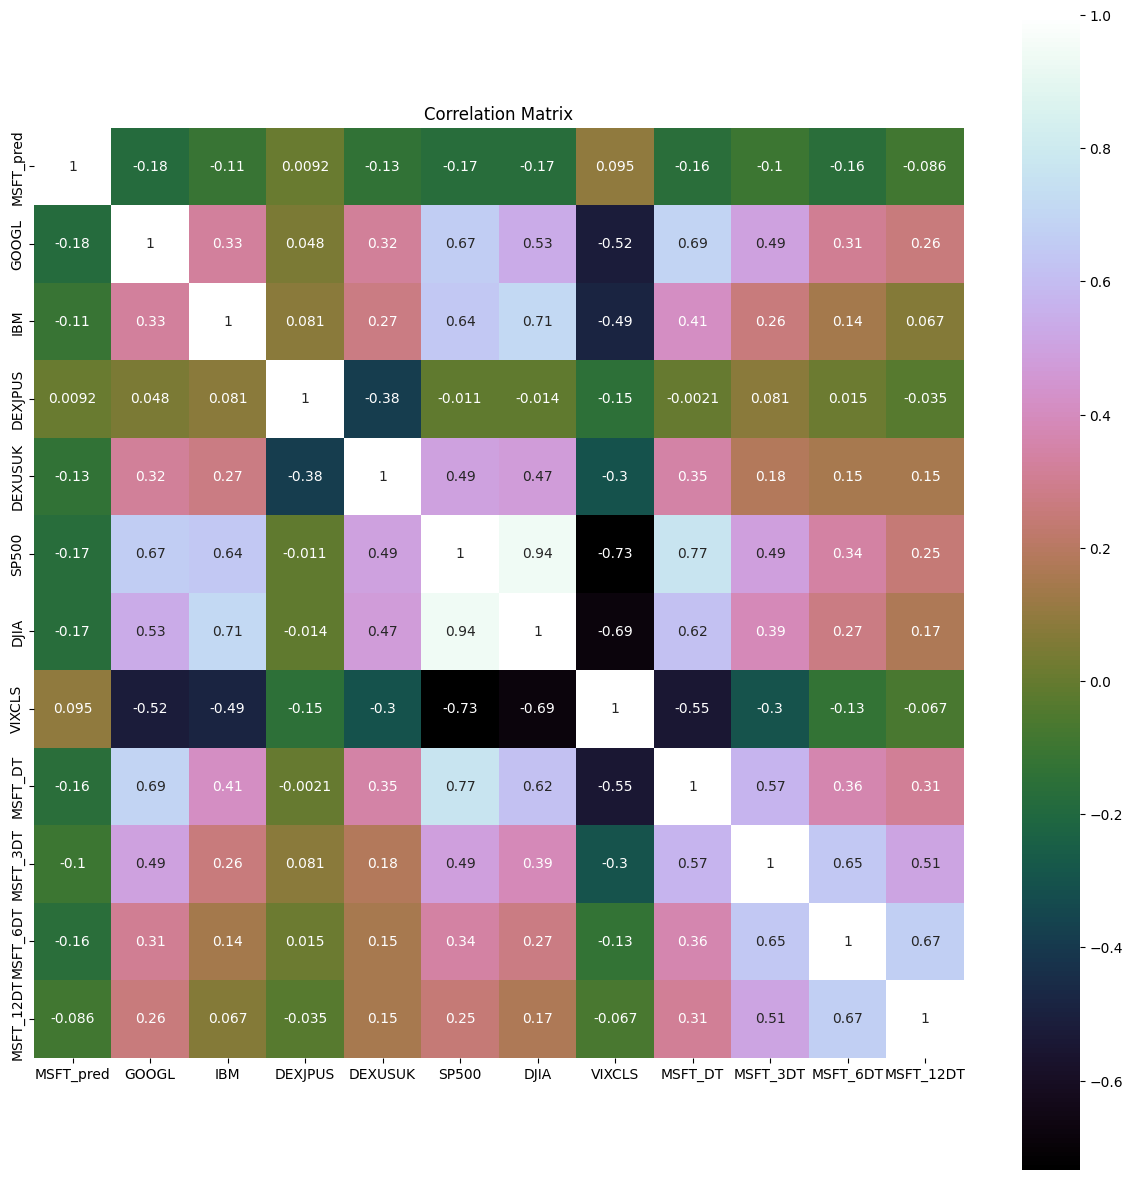

In [ ]:
#check for interdependence between variables
correlation = dataset.corr()
pyplot.figure(figsize=(15,15))
pyplot.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

Looking at the correlation plot above, we see some correlation of the predicted variable with the lagged 5 days, 15days, and 30 days return of MSFT.

<Figure size 1500x1500 with 0 Axes>

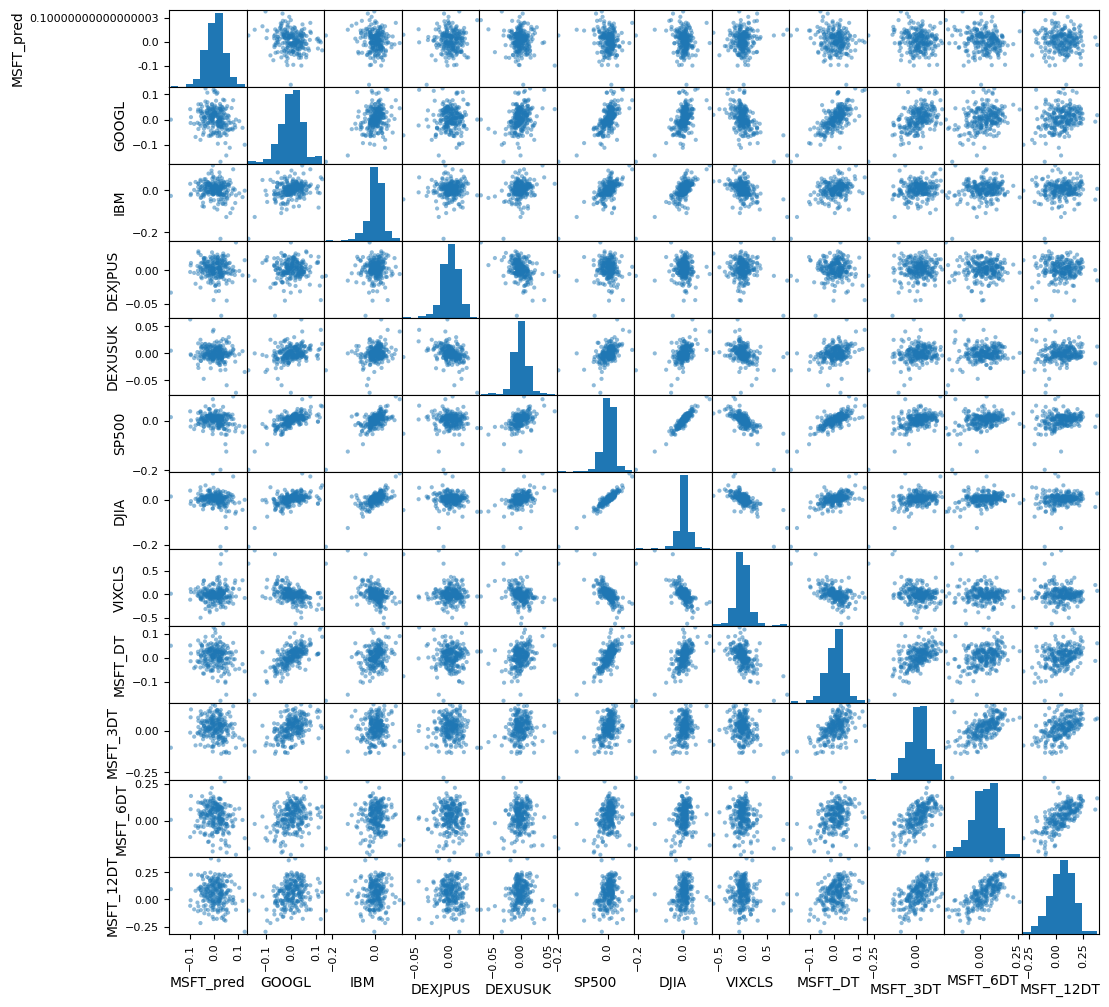

In [ ]:
pyplot.figure(figsize=(15,15))
scatter_matrix(dataset,figsize=(12,12))
pyplot.show()

From the charts, there seems to be more interdependence between the explanatory variables than between the dependent and independent variables.

### TIME SERIES ANALYSIS

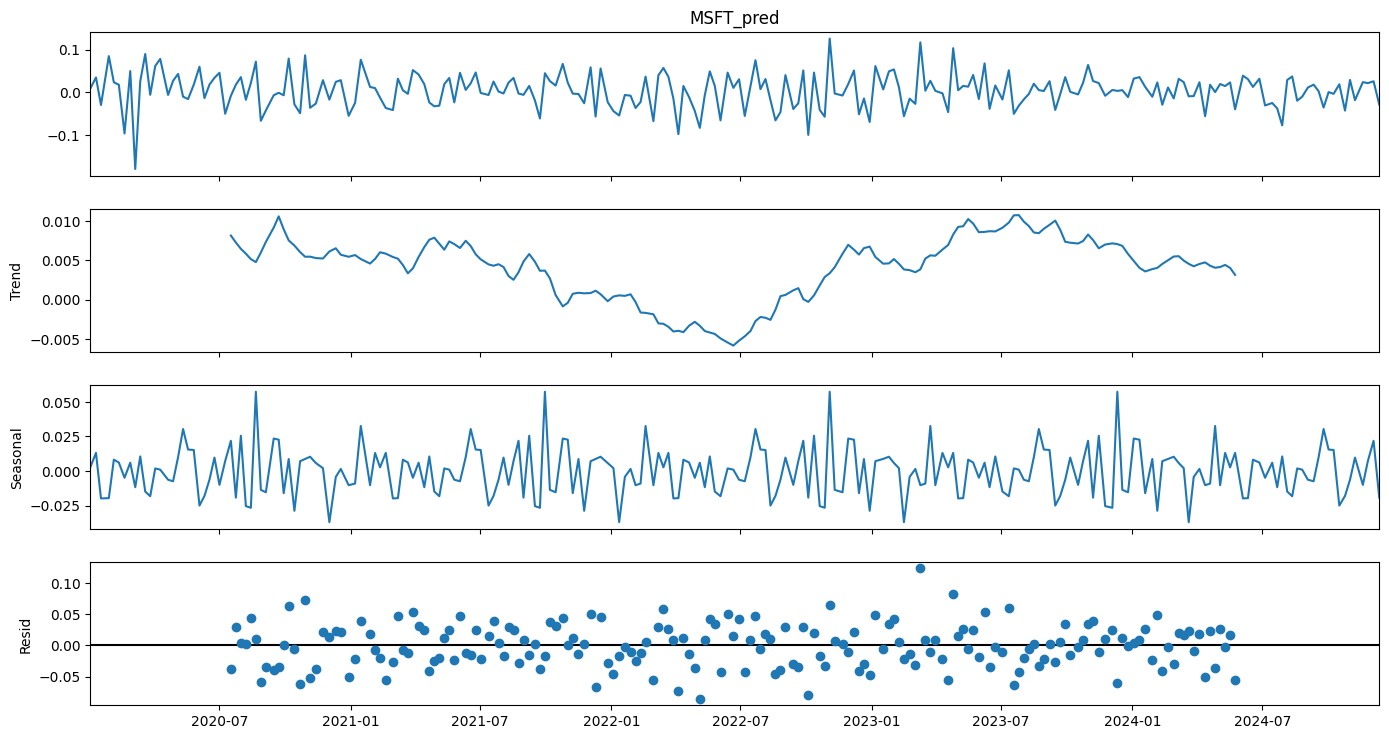

In [ ]:
res = sm.tsa.seasonal_decompose(Y,period=52)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
pyplot.show()

The MSFT exhibits a downward and upward trend in the timeframe analysed

#### DATA PREPARATION

##### FEATURE SELETION

In [ ]:
bestfeatures = SelectKBest(k=5, score_func=f_regression)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
featureScores.nlargest(10,'Score').set_index('Specs')  #print 10 best features

,Score
Specs,
GOOGL,8.121
DJIA,6.983
SP500,6.658
MSFT_DT,6.179
MSFT_6DT,6.029
DEXUSUK,4.192
IBM,3.099
MSFT_3DT,2.459
VIXCLS,2.129


#### DATA PREPARATION


Involves data processing (scaling, normalizing, and standarddizing), data cleaning, looking at
feature importance, and performing feature reduction. The data
available for this case study is relatively clean and doesnt require preprocessing. We have few feautures and hence feature selection wouldnt be needed for now.

#### EVALUATE ALGORITHMS AND MODELS



##### TRAIN TEST SPLIT AND EVALUATION METRICS:
With time series data, the sequence of values
is important. So we do not distribute the dataset into training and test
sets in random fashion, but we select an arbitrary split point in the
ordered list of observations and create two new datasets.

In [ ]:
validation_size = 0.2
train_size = int(len(X) * (1-validation_size))
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(X)]

#####  TEST OPTIONS AND EVALUATION METRICS

To account for inherent randomness in some of the models, we employ the cross-validation process

In [ ]:
num_folds = 10
seed = 7
# scikit is moving away from mean_squared_error.
# In order to avoid confusion, and to allow comparison with other models, we invert the final scores
scoring = 'neg_mean_squared_error'

#####  Machine learning models from Scikit-learn

In [ ]:
#Regression and tree regression algorithms
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR()))

#Neural network algorithms
models.append(('MLP', MLPRegressor()))

#Ensemble models
# Boosting methods
models.append(('ABR', AdaBoostRegressor()))
models.append(('GBR', GradientBoostingRegressor()))
# Bagging methods
models.append(('RFR', RandomForestRegressor()))
models.append(('ETR', ExtraTreesRegressor()))

Once we have selected all the models, we loop over each of them.
First, we run the k-fold analysis. Next, we run the model on the entire
training and testing dataset.
All the algorithms use default tuning parameters. We will calculate
the mean and standard deviation of the evaluation metric for each
algorithm and collect the results for model comparison later

In [ ]:
names = []
kfold_results = []
test_results = []
train_results = []
for name, model in models:
    names.append(name)
    ## k-fold analysis:
    kfold = KFold(n_splits=num_folds)
    #converted mean squared error to positive. Thelower the better
    cv_results = -1* cross_val_score(model, X_train,Y_train, cv=kfold, scoring=scoring)
    kfold_results.append(cv_results)
    # Full Training period
    res = model.fit(X_train, Y_train)
    train_result = mean_squared_error(res.predict(X_train), Y_train)
    train_results.append(train_result)
    # Test results
    test_result = mean_squared_error(res.predict(X_test), Y_test)
    test_results.append(test_result)

    msg = "%s: %f (%f) %f %f" % (name, cv_results.mean(), cv_results.std(), train_result, test_result)
    print(msg)

LR: 0.001985 (0.001186) 0.001717 0.000818
LASSO: 0.001867 (0.000986) 0.001863 0.000745
EN: 0.001867 (0.000986) 0.001863 0.000745
KNN: 0.002121 (0.001132) 0.001408 0.001382
CART: 0.003750 (0.001732) 0.000000 0.002071
SVR: 0.002459 (0.000869) 0.002224 0.001429
MLP: 0.003159 (0.001768) 0.003844 0.002209
ABR: 0.002057 (0.001233) 0.000985 0.000832
GBR: 0.002360 (0.001432) 0.000136 0.001236
RFR: 0.002056 (0.001133) 0.000274 0.000989
ETR: 0.002020 (0.001013) 0.000000 0.000934


#### Cross validation results


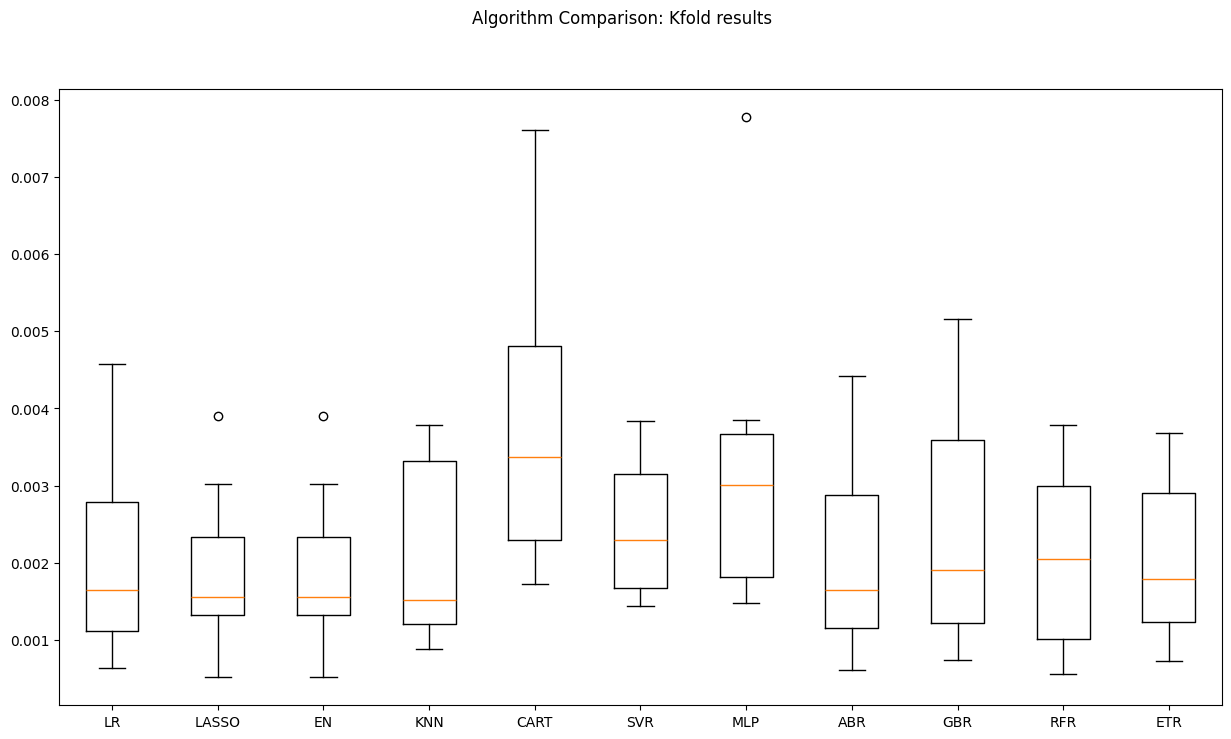

In [ ]:
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison: Kfold results')
ax = fig.add_subplot(111)
pyplot.boxplot(kfold_results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
pyplot.show()


Although the results of a couple of the models look good, we see that
the linear regression and the regularized regression including the
lasso regression (LASSO) and elastic net (EN) seem to perform best.
This indicates a strong linear relationship between the dependent and
independent variables. Going back to the exploratory analysis, we
saw a good correlation and linear relationship of the target variables
with the different lagged MSFT variables.

#### Training and test error

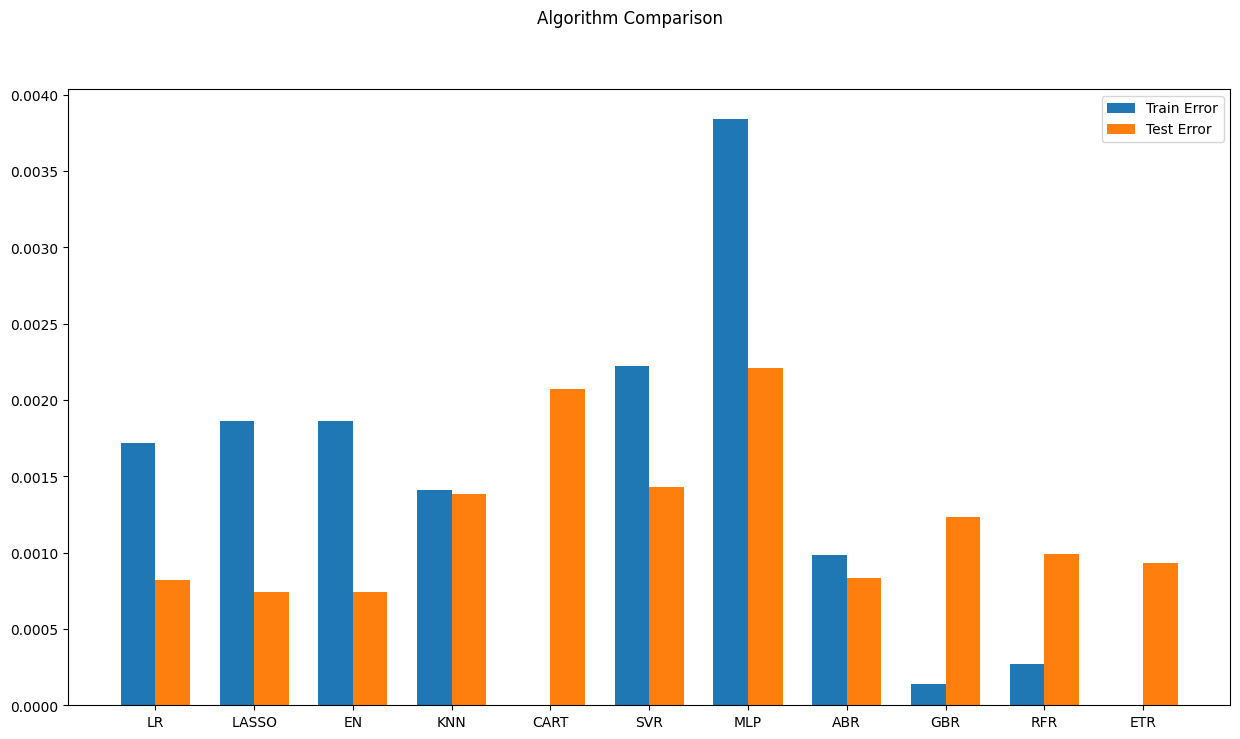

In [ ]:
# compare algorithms
fig = pyplot.figure()
ind = np.arange(len(names)) # the x locations for the groups

width = 0.35 # the width of the bars
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)

pyplot.bar(ind - width/2, train_results, width=width,label='Train Error')
pyplot.bar(ind + width/2, test_results, width=width,label='Test Error')

fig.set_size_inches(15,8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
pyplot.show()


Examining the training and test error, we still see a stronger
performance from the linear models. Some of the algorithms, such as
the decision tree regressor (CART), overfit on the training data and
produced very high error on the test set. Ensemble models such as
gradient boosting regression (GBR) and random forest regression
(RFR) have low bias but high variance. We also see that the artificial
neural network algorithm (shown as MLP in the chart) shows higher
errors in both the training and test setss. This is perhaps due to the
linear relationship of the variables not captured accurately by ANN,
improper hyperparameters, or insufficient training of the model. Our
original intuition from the cross validation results and the scatterplots
also seem to demonstrate a better performance of linear models.


#### Time series–based models: ARIMA and LSTM

The models used so far already embed the time series component by
using a time-delay approach, where the lagged variable is included as
one of the independent variables. However, for the time series–based
models we do not need the lagged variables of MSFT as the
independent variables. Hence, as a first step we remove MSFT’s
previous returns for these models. We use all other variables as the
exogenous variables in these models.


In [ ]:
X_train_ARIMA=X_train.loc[:, ['GOOGL', 'IBM','DEXJPUS', 'SP500', 'DJIA', 'VIXCLS']]
X_test_ARIMA=X_test.loc[:, ['GOOGL', 'IBM', 'DEXJPUS','SP500', 'DJIA', 'VIXCLS']]
tr_len = len(X_train_ARIMA)
te_len = len(X_test_ARIMA)
to_len = len (X)

In [ ]:
modelARIMA = ARIMA(endog=Y_train, exog=X_train_ARIMA, order=[1,0,0])

model_fit = modelARIMA.fit()

error_Training_ARIMA = mean_squared_error(Y_train, model_fit.fittedvalues)
predicted = model_fit.predict(start = tr_len -1 , end =to_len -1, exog = X_test_ARIMA)[1:]
error_Test_ARIMA = mean_squared_error(Y_test,predicted)
error_Test_ARIMA


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

0.0008125327692195903

##### DATA PREPARATION FOR THE LSTM

We need the data
in the form of arrays of all the input variables and the output variables.

The logic behind the LSTM is that data is taken from the previous
day (the data of all the other features for that day—correlated assets
and the lagged variables of MSFT) and we try to predict the next day.
Then we move the one-day window with one day and again predict
the next day. We iterate like this over the whole dataset (of course in
batches). The code below will create a dataset in which X is the set of
independent variables at a given time (t) and Y is the target variable at
the next time (t + 1):

In [ ]:
seq_len = 2 #Length of the seq for the LSTM

Y_train_LSTM, Y_test_LSTM = np.array(Y_train)[seq_len-1:], np.array(Y_test)
X_train_LSTM = np.zeros((X_train.shape[0]+1-seq_len,seq_len, X_train.shape[1])) #create 3 dimensional zero matrix
X_test_LSTM = np.zeros((X_test.shape[0], seq_len, X.shape[1])) #create 3 dimensional zero matrix

for i in range(seq_len):
    X_train_LSTM[:, i, :] = np.array(X_train)[i:X_train.shape[0]+i+1-seq_len, :]
    X_test_LSTM[:, i, :] = np.array(X)[X_train.shape[0]+i-1:X.shape[0]+i+1-seq_len, :]

In the next step, we create the LSTM architecture. As we can see, the
input of the LSTM is in X_train_LSTM, which goes into 50 hidden
units in the LSTM layer and then is transformed to a single output—
the stock return value.

In [ ]:
# LSTM Network
def create_LSTMmodel(learning_rate = 0.01, momentum=0.0):
    model = Sequential()
    model.add(LSTM(50, input_shape=(X_train_LSTM.shape[1],X_train_LSTM.shape[2])))
    #More cells can be added if needed
    model.add(Dense(1))
    optimizer = SGD(learning_rate=learning_rate, momentum=momentum)
    model.compile(loss='mse', optimizer='adam')
    return model

LSTMModel = create_LSTMmodel(learning_rate = 0.01,momentum=0.0)
LSTMModel_fit = LSTMModel.fit(X_train_LSTM,Y_train_LSTM, validation_data=(X_test_LSTM, Y_test_LSTM),epochs=330, batch_size=72, verbose=0, shuffle=False)


After fitting the LSTM model with the data, we look at the change in
the model performance metric over time simultaneously in the
training set and the test set.

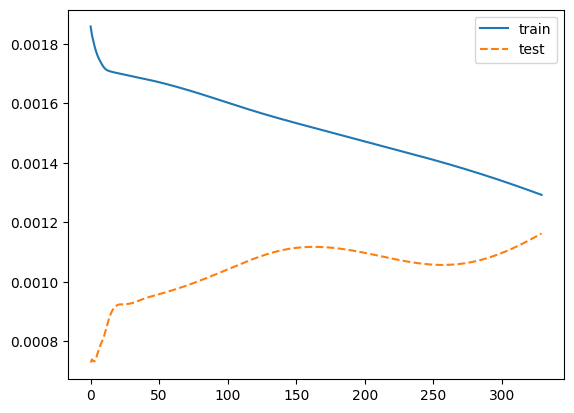

In [ ]:
pyplot.plot(LSTMModel_fit.history['loss'],label='train', )
pyplot.plot(LSTMModel_fit.history['val_loss'], '--',label='test',)
pyplot.legend()
pyplot.show()

In [ ]:
error_Training_LSTM = mean_squared_error(Y_train_LSTM,LSTMModel.predict(X_train_LSTM))
predicted = LSTMModel.predict(X_test_LSTM)
error_Test_LSTM = mean_squared_error(Y_test,predicted)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


Now, in order to compare the time series and the deep learning models, we append the result of these models to the results of the supervised regression–based models

In [ ]:
test_results.append(error_Test_ARIMA)
test_results.append(error_Test_LSTM)
train_results.append(error_Training_ARIMA)
train_results.append(error_Training_LSTM)
names.append("ARIMA")
names.append("LSTM")

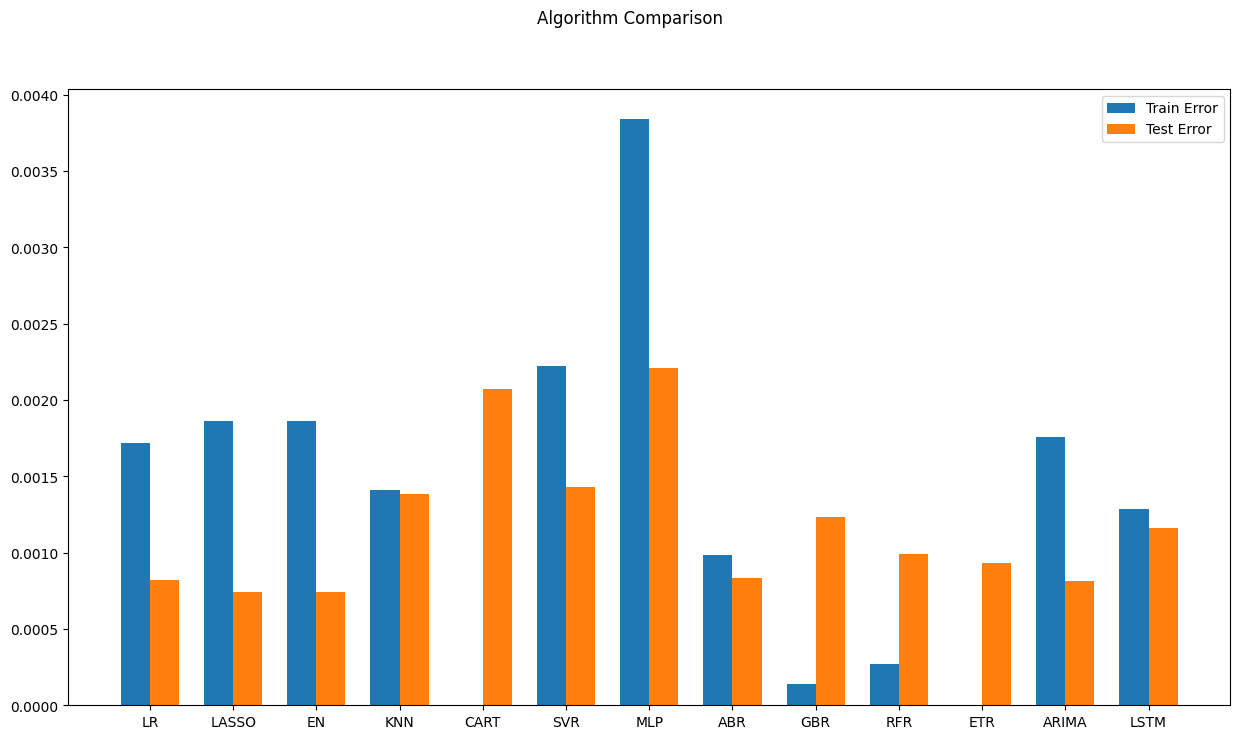

In [ ]:
# compare algorithms
fig = pyplot.figure()
ind = np.arange(len(names)) # the x locations for the groups

width = 0.35 # the width of the bars
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)

pyplot.bar(ind - width/2, train_results, width=width,label='Train Error')
pyplot.bar(ind + width/2, test_results, width=width,label='Test Error')

fig.set_size_inches(15,8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
pyplot.show()


the ARIMA model outperforms the LSTM model in the test set. Hence, we select
the ARIMA model for model tuning.


#### MODEL TUNING AND GRID SEARCH


The order of the ARIMA model was set to (1,0,0). So we perform a
grid search with different p, d, and q combinations in the ARIMA
model’s order and select the combination that minimizes the fitting
error.

In [ ]:
import warnings

In [ ]:

# evaluate an ARIMA model for a given order (p,d,q)
#Assuming that the train and Test Data is already defined before
def evaluate_arima_model(arima_order):
    #predicted = list()
    modelARIMA = ARIMA(endog=Y_train,exog=X_train_ARIMA,order=arima_order)
    model_fit = modelARIMA.fit()
    error = mean_squared_error(Y_train, model_fit.fittedvalues)
    return error

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.7f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.7f' % (best_cfg, best_score))

# evaluate parameters
p_values = [0, 1, 2]
d_values = range(0, 2)
q_values = range(0, 2)
warnings.filterwarnings("ignore")
evaluate_models(p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=0.0017589
ARIMA(0, 0, 1) MSE=0.0017587
ARIMA(0, 1, 0) MSE=0.0029807
ARIMA(0, 1, 1) MSE=0.0018320
ARIMA(1, 0, 0) MSE=0.0017587
ARIMA(1, 0, 1) MSE=0.0017584
ARIMA(1, 1, 0) MSE=0.0026108
ARIMA(1, 1, 1) MSE=0.0018378
ARIMA(2, 0, 0) MSE=0.0017575
ARIMA(2, 0, 1) MSE=0.0017574
ARIMA(2, 1, 0) MSE=0.0023329
ARIMA(2, 1, 1) MSE=0.0018677
Best ARIMA(2, 0, 1) MSE=0.0017574


We see that the ARIMA model with the order (2,0,1) is the best
performer out of all the combinations tested in the grid search,
although there isn’t a significant difference in the mean squared error
(MSE) with other combinations. This means that the model with the
autoregressive lag of two and moving average of one yields the best
result. We should not forget the fact that there are other exogenous
variables in the model that influence the order of the best ARIMA
model as well.

#### FINALIZE THE MODEL

In the last step we will check the finalized model on the test set.

In [ ]:
# prepare model
modelARIMA_tuned=ARIMA(endog=Y_train,exog=X_train_ARIMA,order=[2,0,1])
model_fit_tuned = modelARIMA_tuned.fit()

In [ ]:
# estimate accuracy on validation set
predicted_tuned = model_fit_tuned.predict(start = tr_len -1 ,end = to_len -1, exog = X_test_ARIMA)[1:]
print(mean_squared_error(Y_test,predicted_tuned))

0.0008100453183340887


The MSE of the model on the test set looks good and is actually less
than that of the training set.
In the last step, we will visualize the output of the selected model and
compare the modeled data against the actual data. In order to
visualize the chart, we convert the return time series to a price time
series. We also assume the price at the beginning of the test set as one
for the sake of simplicity. Let us look at the plot of actual versus
predicted data:

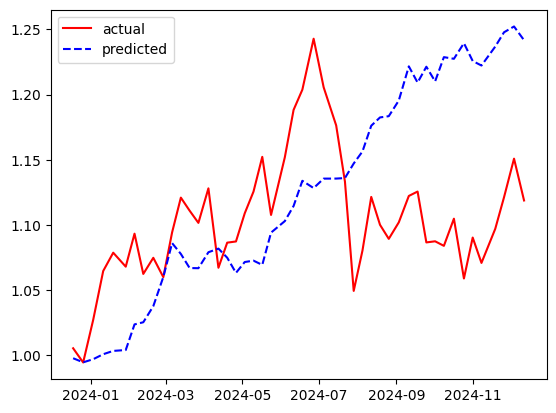

In [ ]:
# plotting the actual data versus predicted data
predicted_tuned.index = Y_test.index
pyplot.plot(np.exp(Y_test).cumprod(), 'r',
label='actual',)
# plotting t, a separately
pyplot.plot(np.exp(predicted_tuned).cumprod(), 'b--',
label='predicted')
pyplot.legend()
pyplot.rcParams["figure.figsize"] = (8,5)
pyplot.show()